# Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import requests,io
import cv2
#import astroalign
import math
from astropy.io import fits
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm, SigmaClip
from astropy.table import QTable
from astropy.utils.exceptions import AstropyDeprecationWarning


from photutils.background import LocalBackground, MMMBackground,Background2D,MedianBackground
from photutils.detection import DAOStarFinder
from photutils.psf import IterativePSFPhotometry, IntegratedGaussianPRF,prepare_psf_model, IterativelySubtractedPSFPhotometry, DAOGroup, SourceGrouper

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Load the reduced data

In [2]:
data_path = 'wednesday'

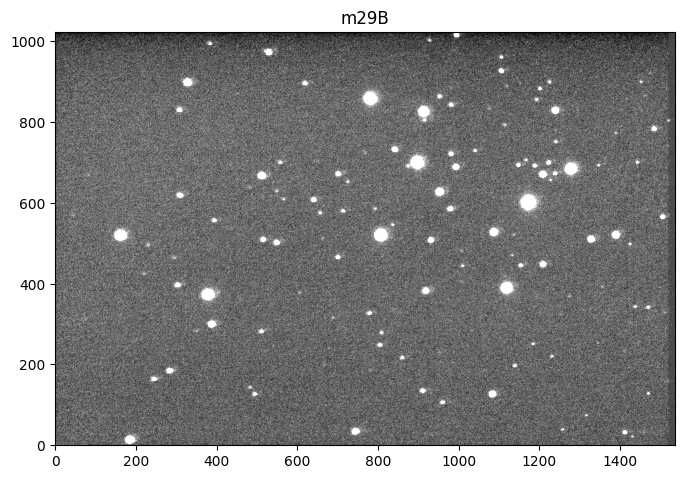

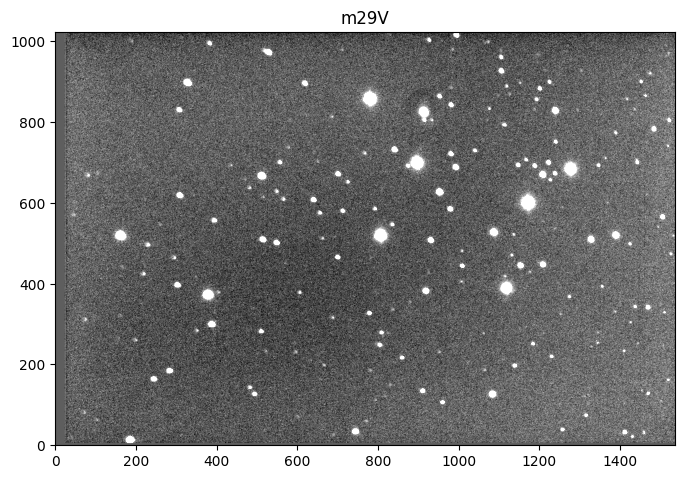

In [3]:
data = {}
data["M29B"] = np.load(f'{data_path}/M29B.npy')
data["M29V"] = np.load(f'{data_path}/M29G.npy')
#data["M29V"] =dataM29V[0]


lo,up= np.percentile(data["M29B"],1),np.percentile(data["M29B"],99)
plt.figure(figsize=(8, 8))
plt.imshow(data["M29B"], cmap='gray', origin='lower', clim=(lo,up))
plt.title(f"m29B")
plt.show()

lo,up= np.percentile(data["M29V"],1),np.percentile(data["M29V"],99)
plt.figure(figsize=(8, 8))
plt.imshow(data["M29V"], cmap='gray', origin='lower', clim=(lo,up))
plt.title(f"m29V")
plt.show()

# Background Estimation

In [4]:
for key, image in data.items():
    print(image.shape)

(1024, 1536)
(1024, 1536)


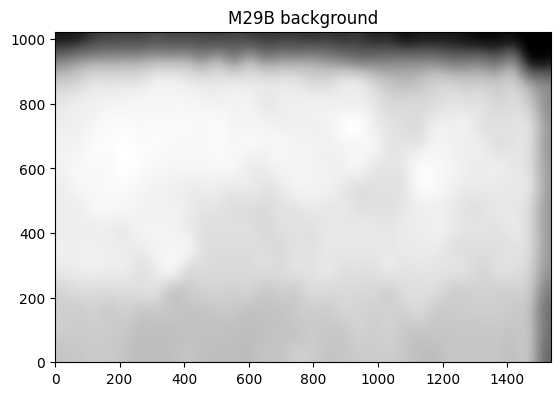

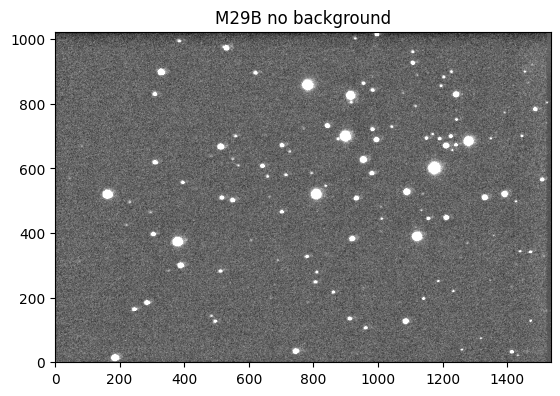

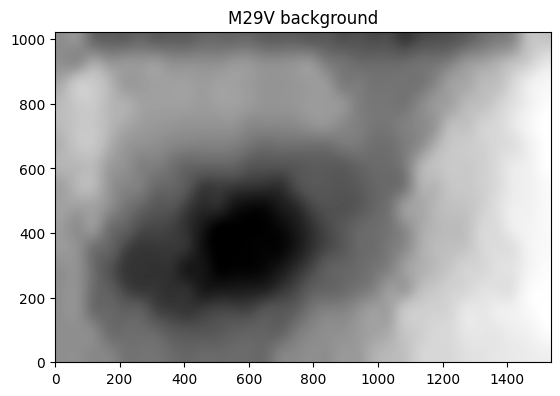

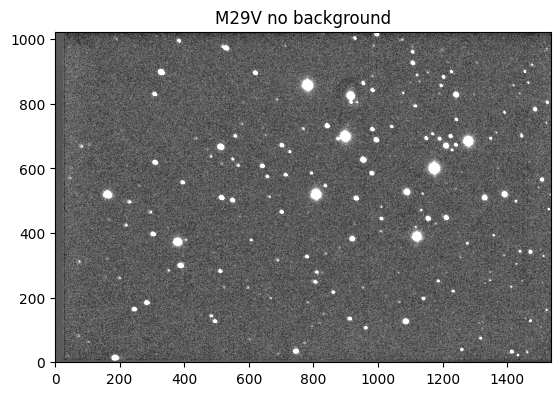

In [5]:
bkgs={}
bkg_uncs = {}
images_nobkg={}
for key, image in data.items():
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image,
                       (64,48), #they say it works better if data is covered by int nb of boxes
                       filter_size=(3,3),sigma_clip=sigma_clip,
                    bkg_estimator=bkg_estimator)
    bkgs[key] = bkg.background
    bkg_uncs[key] = bkg.background_rms
    plt.title(f'{key} background')
    plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
    plt.show()

    images_nobkg[key]=image-bkg.background
    lo,up= np.percentile(images_nobkg[key],1),np.percentile(images_nobkg[key],99)
    plt.imshow(images_nobkg[key], cmap='gray', origin='lower', clim=(lo,up))
    plt.title(f'{key} no background')
    plt.show()

data=images_nobkg


    

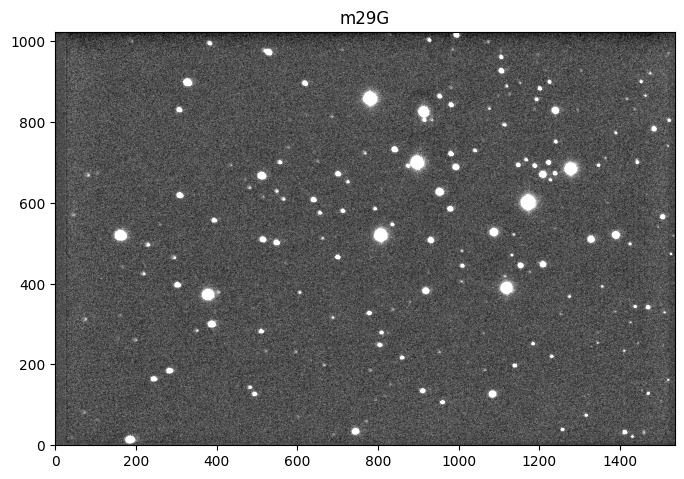

In [6]:
m29G = np.median(np.stack([data["M29B"], data["M29V"]], axis=0), axis=0)
lo,up= np.percentile(m29G,1),np.percentile(m29G,99)

plt.figure(figsize=(8, 8))
plt.imshow(m29G, cmap='gray', origin='lower', clim=(lo,up))
plt.title(f"m29G")
plt.show()

In [7]:
# Check data types
print("M29B data type:", data["M29B"].dtype)
print("M29V data type:", data["M29V"].dtype)

# Check image dimensions
print("M29B shape:", data["M29B"].shape)
print("M29V shape:", data["M29V"].shape)

M29B data type: float64
M29V data type: float64
M29B shape: (1024, 1536)
M29V shape: (1024, 1536)


# Get 2D FWHM

Found 84 stars in image M29B


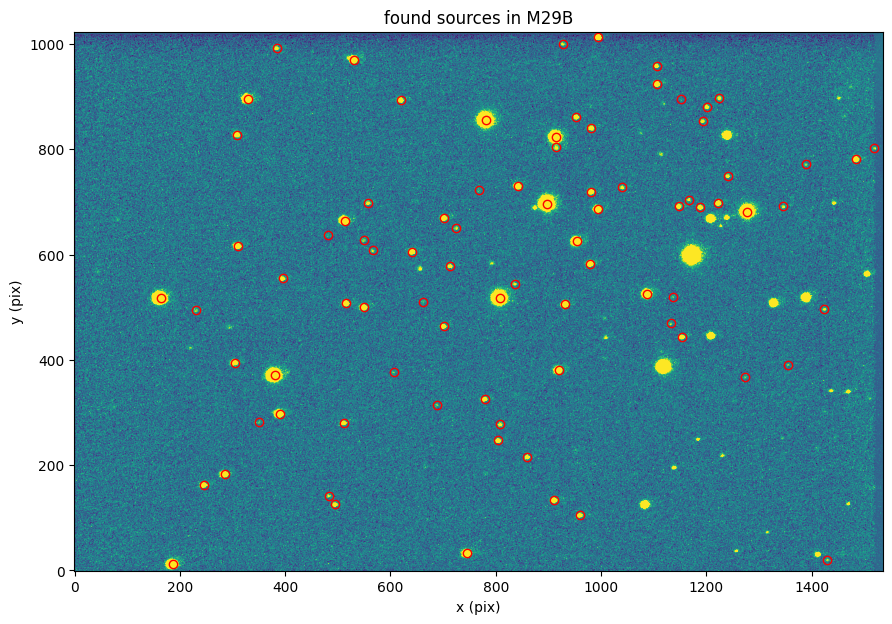

     x-FWHM 5.878199417974393+/-0.173934340273371 (pix) for this M29B 
     y-FWHM 6.807785099106998+/-0.2741350716705404 (pix) for this M29B 
     FWHM 6.342992258540695+/-0.22299100306623273 (pix) for this M29B 
Found 136 stars in image M29V


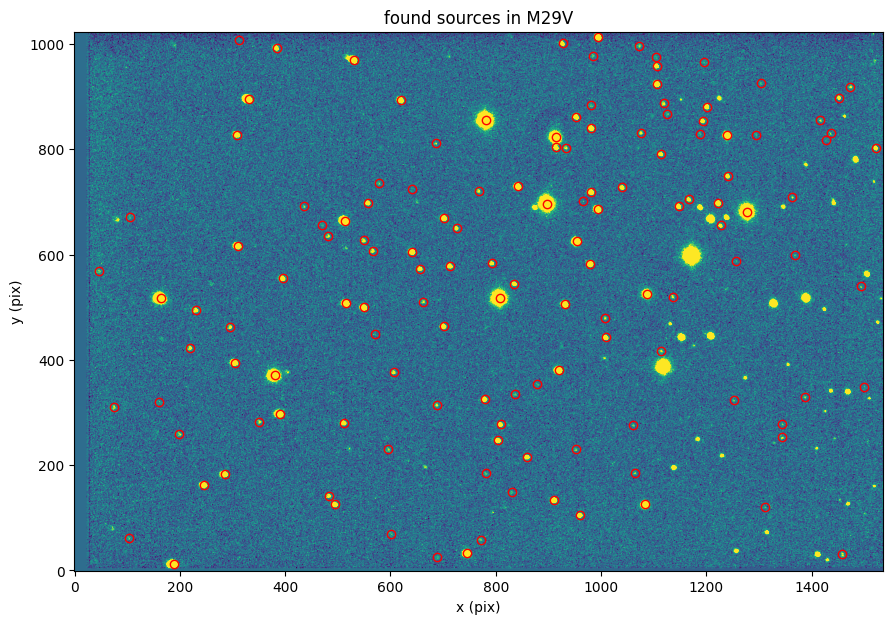

     x-FWHM 6.017827884406646+/-0.22776742577785625 (pix) for this M29V 
     y-FWHM 5.943938336245691+/-0.3300826621364247 (pix) for this M29V 
     FWHM 6.099428078317892+/-0.20894654098136853 (pix) for this M29V 


In [8]:
xfwhms = {}
yfwhms = {}
fwhms = {}
for key, image in data.items():
    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=5)
    ## Find stars
    daofind = DAOStarFinder(fwhm=15, threshold=6.0*std)  ##peakmax to exclude saturated stars!!
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars 
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1][0:nbright]
    brsources = sources[brightest]

    ##########
    #get fwhm
    rmax = 25
    (ny,nx) = np.shape(image)
    from astropy.modeling import models,fitting
    fit_g = fitting.LevMarLSQFitter()
    allxfwhm, allyfwhm = np.zeros(len(brsources)),np.zeros(len(brsources))
    allfwhm,alltheta = np.zeros(len(brsources)),np.zeros(len(brsources))
    for i,src in enumerate(brsources):
        if int(src['ycentroid']) > rmax and int(src['ycentroid']) < ny-rmax and \
            int(src['xcentroid']) > rmax and int(src['xcentroid']) < nx-rmax:
            img = image[int(src['ycentroid'])-rmax:int(src['ycentroid'])+rmax,
                        int(src['xcentroid'])-rmax:int(src['xcentroid'])+rmax]
            subx,suby = np.indices(img.shape) # instead of meshgrid
            p_init = models.Gaussian2D(amplitude=np.max(img),x_mean=rmax,y_mean=rmax,x_stddev=1.0,y_stddev=1.0)
            fitgauss = fit_g(p_init, subx, suby, img - np.min(img))
            allxfwhm[i] = np.abs(fitgauss.x_stddev.value)
            allyfwhm[i] = np.abs(fitgauss.y_stddev.value)
            allfwhm[i] = 0.5*(allxfwhm[i]+allyfwhm[i])
            alltheta[i] = fitgauss.theta.value
    xfwhm,yfwhm = np.median(allxfwhm)*gaussian_sigma_to_fwhm,np.median(allyfwhm)*gaussian_sigma_to_fwhm
    fwhm = np.median(allfwhm)*gaussian_sigma_to_fwhm
    sigfwhm, sigxfwhm, sigyfwhm = np.std(allfwhm), np.std(allxfwhm), np.std(allyfwhm)
    medtheta = np.median(alltheta)
    print(f"     x-FWHM {xfwhm}+/-{sigxfwhm} (pix) for this {key} ")
    print(f"     y-FWHM {yfwhm}+/-{sigyfwhm} (pix) for this {key} ")
    print(f"     FWHM {fwhm}+/-{sigfwhm} (pix) for this {key} ")

    fwhms[key] = fwhm
    xfwhms[key] = xfwhm
    yfwhms[key] = yfwhm


# 2d gaussians

In [9]:
twodgauss = {}
psf_models = {}
for key, image in data.items():
    twodgauss[key] =  models.Gaussian2D(x_stddev=xfwhms[key]/gaussian_sigma_to_fwhm,
                                        y_stddev=yfwhms[key]/gaussian_sigma_to_fwhm,
                                        )
    
    #twodgauss[key].xname = 'x'
    #twodgauss[key].yname = 'y'
    #twodgauss[key].fluxname = 'amplitude'

    psf_models[key] = prepare_psf_model(twodgauss[key],xname='x_mean',yname='y_mean',fluxname='amplitude')


    

# Find point sources more accuretly with FWHM
more stars found this way:)

In [10]:
fwhms

{'M29B': 6.342992258540695, 'M29V': 6.099428078317892}

Found 98 stars in image M29B


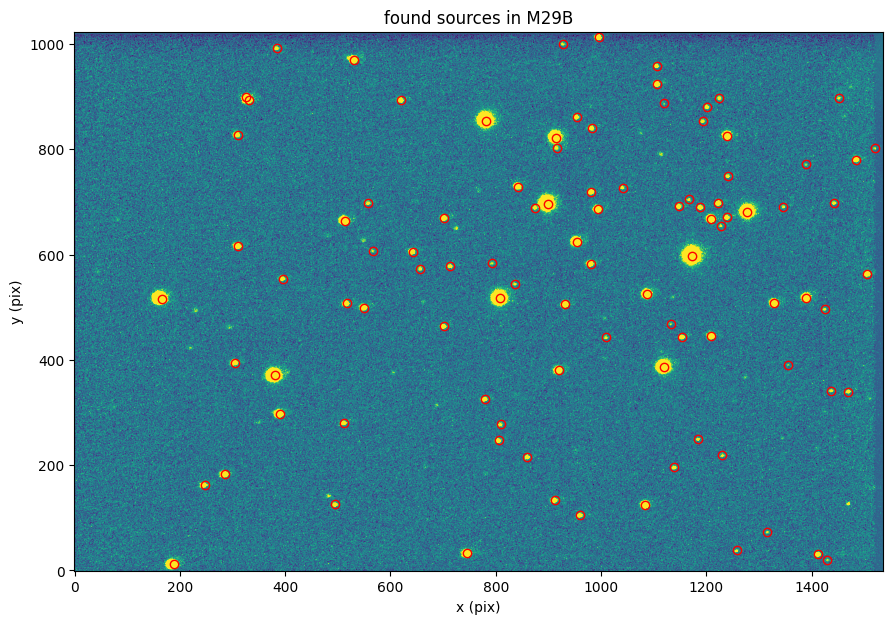

Found 147 stars in image M29V


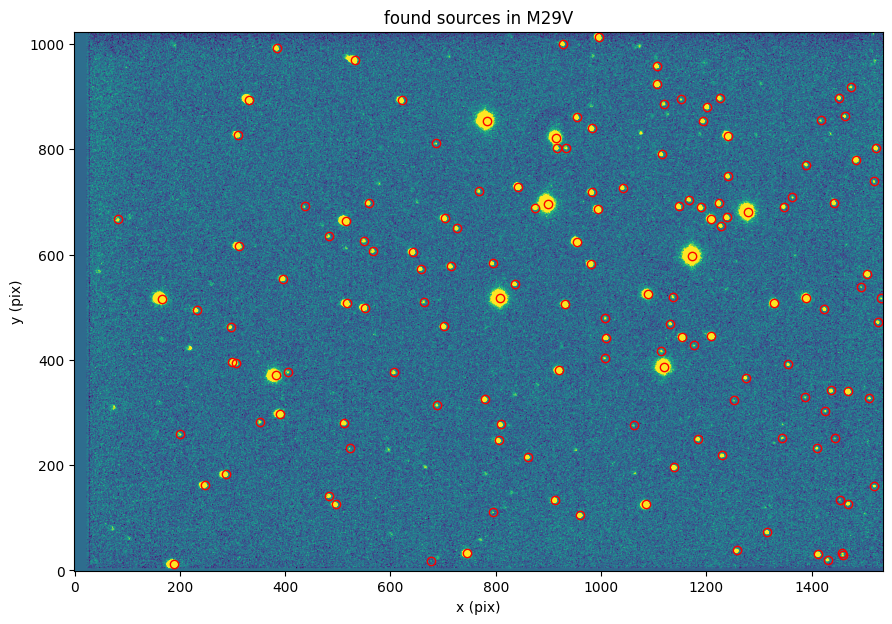

In [11]:
x_inits = {}
y_inits = {}

daofinds = {}

for key, image in data.items():

    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=5)
    ## Find stars
    daofind = DAOStarFinder(fwhm=fwhms[key], threshold=6.0*std)  ##peakmax to exclude saturated stars!!
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    daofinds[key]=daofind

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars and save
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1][0:nbright]
    brsources = sources[brightest]

    x_inits[key] = brsources['xcentroid']
    y_inits[key] = brsources['ycentroid']



# Iterative PSF Photometry :)


In [36]:
phots = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=AstropyDeprecationWarning)
    for key, image in data.items():

        group = SourceGrouper(fwhms[key])
        itPSF = IterativePSFPhotometry(
            grouper=group ,     
            psf_model=IntegratedGaussianPRF(sigma=fwhms[key]/gaussian_sigma_to_fwhm),
            finder=daofinds[key],
            fit_shape=(5,5), #play with this, this may be small
            aperture_radius=4 #play with this as well
        )
        init_params = QTable()
        init_params['x'] = x_inits[key]
        init_params['y'] = y_inits[key]

        phots[key] = itPSF(image- bkgs[key], 
                           init_params = init_params,
                           error=bkg_uncs[key]
                    )

In [13]:
phots['M29B']

<QTable length=211>
  id  group_id iter_detected ...           cfit          flags
int32  int32       int32     ...         float64         int32
----- -------- ------------- ... ----------------------- -----
    1        1             1 ...   0.0008441908402462782     0
    2        2             1 ...    0.000805686159789716     0
    3        3             1 ...   0.0012257548900755026     0
    4        4             1 ...   0.0005597663292878887     0
    5        5             1 ...   0.0011936965830457644     0
    6        6             2 ...   0.0006348031002668471     0
    7        7             2 ...  -0.0014934103618549994     4
    8        8             2 ...  -9.430982564609797e-06    12
    9        9             2 ...   0.0011334213910990905     0
   10       10             2 ...  -0.0018442480465041369     4
  ...      ...           ... ...                     ...   ...
  202      189             3 ...  -5.616602855532316e-06    12
  203      190             3 ...  -8.455771740306391e-06    12
  204      191             3 ... -1.4296812488815268e-05    12
  205      192             3 ...  -6.408021177212788e-05    12
  206      193             3 ...  3.9844650513657115e-05     0
  207      194             3 ...   -7.19813550503678e-06    12
  208      195             3 ...     0.02009951295889014     0
  209      196             3 ...  -3.088572585701513e-06    12
  210      197             3 ... -2.7460816862566977e-06    12
  211      198             3 ...    0.008502007097343407     2

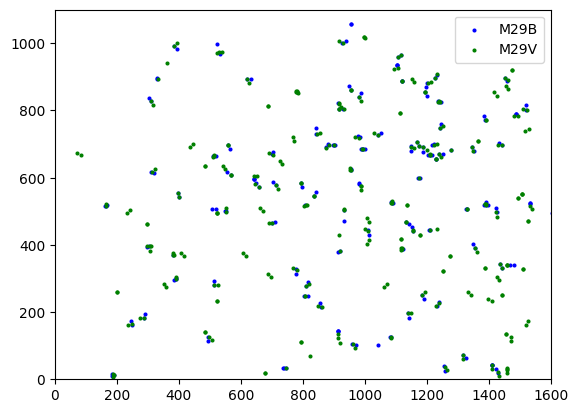

In [37]:
for key, phot in phots.items():
    #plt.clf()
    if key=='M29V':
        plt.scatter(phot['x_fit'],phot['y_fit'], marker='.', color='green', label='M29V', s=15)
    if key=='M29B':
        plt.scatter(phot['x_fit'],phot['y_fit'], marker='.', color='blue', label='M29B', s=15)

plt.xlim(0, 1600)  
plt.ylim(0, 1100) 
plt.legend()
plt.show()


In [38]:
# CORRESPOND STARS WITH B AND V FILTER

#make array with pairs of coordinates to be easier to work with
points=[]
point_pairs1 = np.column_stack(((np.array(phots['M29B']['x_fit'])), np.array(phots['M29B']['y_fit'])))
point_pairs2 = np.column_stack(((np.array(phots['M29V']['x_fit'])), np.array(phots['M29V']['y_fit'])))
points = np.concatenate((point_pairs1, point_pairs2))
print(points.shape)

#function to calculate the distance between two coordinates
def distance(coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

#function to merge coordinates that are considered closed
def merge_close_coordinates(coordinates, max_distance):
    merged_coordinates = []
    n = len(coordinates)

    #create a boolean array to keep track of merged coordinates
    merged = [False] * n

    for i in range(n):
        if not merged[i]:
            current_coordinate = coordinates[i]
            merged_coordinate = current_coordinate

            for j in range(i + 1, n):
                if not merged[j]:
                    if distance(current_coordinate, coordinates[j]) <= max_distance:
                        # Merge coordinates that are close
                        merged_coordinate = (
                            (merged_coordinate[0] + coordinates[j][0]) / 2,
                            (merged_coordinate[1] + coordinates[j][1]) / 2
                        )
                        merged[j] = True

            merged_coordinates.append(merged_coordinate)
    return merged_coordinates

#maximum distance within which points should be considered close
max_distance = 50.0 

merged_coords = merge_close_coordinates(points, max_distance) #list
merged_array=np.array(merged_coords) #array
print(merged_array.shape)


(524, 2)
(104, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


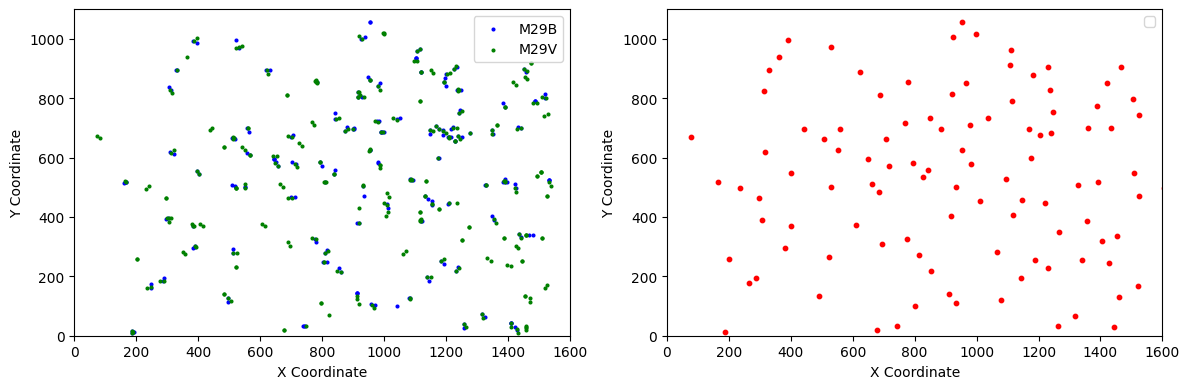

In [39]:
#SEE THE DIFFERENCE OF CORRESPOND STARS

plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

plt.subplot(1, 2, 1) 
for key, phot in phots.items():
    #plt.clf()
    if key=='M29V':
        plt.scatter(phot['x_fit'],phot['y_fit'], marker='.', color='green', label='M29V', s=15)
    if key=='M29B':
        plt.scatter(phot['x_fit'],phot['y_fit'], marker='.', color='blue', label='M29B', s=15)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 1600)  
plt.ylim(0, 1100) 
plt.legend()


plt.subplot(1, 2, 2)  
x_coords, y_coords = merged_array[:, 0], merged_array[:, 1]
plt.scatter(x_coords, y_coords, color='red', s=10)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 1600)  
plt.ylim(0, 1100) 
plt.legend()


plt.tight_layout()
plt.show()


In [43]:
import numpy as np
from astropy.table import Table
from scipy.spatial import distance

#distância máxima permitida
distancia_maxima = 30

#para o B filter
#função que encontra a coordenada mais próxima e o valor do fluxo correspondente
def encontrar_coordenada_mais_proxima(coordenada,key):
    distancias = np.sqrt((phots[key]['x_fit'] - coordenada[0])**2 + (phots[key]['y_fit'] - coordenada[1])**2)
    indice_min = np.argmin(distancias)
    distancia_min = distancias[indice_min]
    
    if distancia_min <= distancia_maxima:
        valor_de_A = phots[key]['flux_fit'][indice_min]
        return coordenada[0], coordenada[1], valor_de_A
    else:
        return None

coordenadas_proximas_m29b = []

for coord in merged_array:
    coordenada_proxima = encontrar_coordenada_mais_proxima(coord,'M29B')
    if coordenada_proxima is not None:
        coordenadas_proximas_m29b.append(coordenada_proxima)

#so queria que esta merda funcionasse depois mete se isto mais eficiente num loop

#para o V filter

coordenadas_proximas_m29v = []

for coord in merged_array:
    coordenada_proxima = encontrar_coordenada_mais_proxima(coord,'M29V' )
    if coordenada_proxima is not None:
        coordenadas_proximas_m29v.append(coordenada_proxima)

coordenadas_proximas_m29v=np.array(coordenadas_proximas_m29v)
coordenadas_proximas_m29b=np.array(coordenadas_proximas_m29b)

print(coordenadas_proximas_m29b.shape)
print(coordenadas_proximas_m29v.shape)



(78, 3)
(102, 3)


In [44]:
# Inicialize uma lista para armazenar os elementos com as duas primeiras variáveis iguais
coordenadas_proximas_m29b_comum = []
coordenadas_proximas_m29v_comum = []

# Itere pelos elementos de array1 e compare com array2
for x in coordenadas_proximas_m29b:
    for y in coordenadas_proximas_m29v:
        if np.array_equal(x[:2], y[:2]):
            coordenadas_proximas_m29b_comum.append(x)
            coordenadas_proximas_m29v_comum.append(y)
            

# Converta as listas resultantes em arrays numpy, se necessário
coordenadas_proximas_m29b_comum = np.array(coordenadas_proximas_m29b_comum)
coordenadas_proximas_m29v_comum = np.array(coordenadas_proximas_m29v_comum)

print(coordenadas_proximas_m29b_comum.shape)
print(coordenadas_proximas_m29v_comum.shape)

(76, 3)
(76, 3)


In [45]:
magnitudes=[]

#for id in phots['M29B']:
#for key, phot in phots.items():
    #plt.clf()
    #if key=='M29V':
        #abs(phot['flux_fit'])
magnitudes.append(-2.5 * np.log10(abs(coordenadas_proximas_m29b_comum.T[2]) / 45))
    #if key=='M29B':
magnitudes.append(-2.5 * np.log10(abs(coordenadas_proximas_m29v_comum.T[2]) / 70))

magnitudes=np.array(magnitudes)
magnitudes.shape
#0-B
#1-V

color_indexBV=magnitudes[0]-magnitudes[1]

#TEM QUE SE CALCULAR MAGNITUDES ABSOLUTAS A PARTIR DE UMA ESTRELA PADRAO

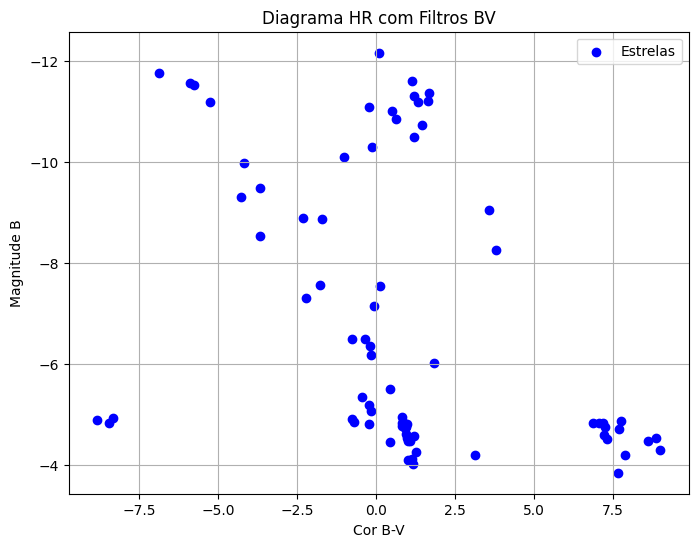

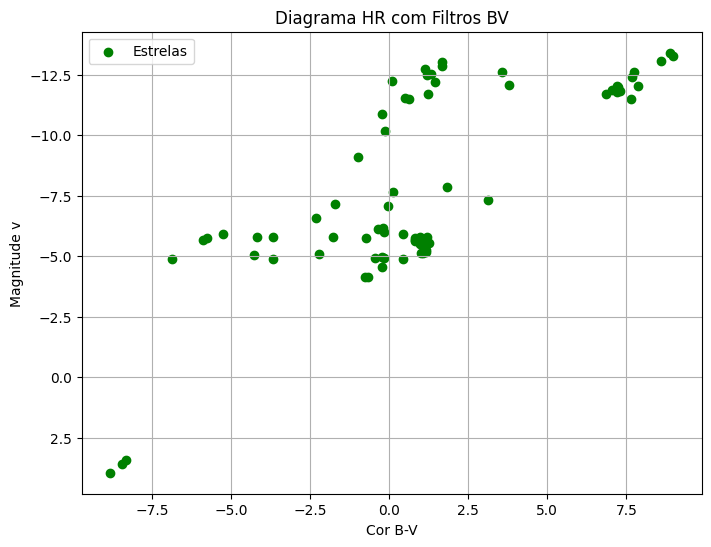

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(color_indexBV, magnitudes[0], marker='o', label='Estrelas', color='blue')
plt.xlabel('Cor B-V')
plt.ylabel('Magnitude B')
plt.title('Diagrama HR com Filtros BV')
plt.grid(True)

#inverter o eixo y, magnitude aumenta à medida que se vai para baixo no diagrama
plt.gca().invert_yaxis()

plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(color_indexBV, magnitudes[1], marker='o', label='Estrelas', color='green')
plt.xlabel('Cor B-V')
plt.ylabel('Magnitude v')
plt.title('Diagrama HR com Filtros BV')
plt.grid(True)

#inverter o eixo y, magnitude aumenta à medida que se vai para baixo no diagrama
plt.gca().invert_yaxis()

plt.legend()
plt.show()